In [347]:
import pandas as pd
import re

In [348]:
df = pd.read_json('../data/posts_preprocessed.json')

In [349]:
posts = df.prep_body.values.tolist()

In [350]:
# removing some last minute stop phrases
stops = [" want "," would "," make "," know ","show contact info",
         " get ","contact info", " go ", " someth ", " re ", " ve "
         " sound "," musician "," let "," like ", " also "]
for stop in stops:
    posts = [ re.sub(stop,'',x) for x in posts ]

## TF-IDF Vectorizer

In [351]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [352]:
ngrams = (1,2)

vectorizer = TfidfVectorizer(ngram_range=ngrams,max_df=.4)

vectorizer.fit(posts)
x = vectorizer.transform(posts)
x.shape

(18366, 586407)

## NMF Topic Model

In [353]:
no_topics = 18
# lda = LatentDirichletAllocation(n_topics=no_topics).fit(x)
nmf = NMF(n_components=no_topics).fit(x)

In [354]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print("\n".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print('\n')

### Topics by top words

In [355]:
topic_descriptions

{0: 'New Music Projects',
 1: 'Studio and Production Services',
 2: 'Music Teachers for Hire',
 3: 'Bass Players',
 4: 'Drummers',
 5: 'Live Music for Your Event!',
 6: 'Singer/Songwriters',
 7: 'Music Video Specialists',
 8: 'Rehearsal Spaces',
 9: 'Spammed Producer Ads http://www.producemytunes.com ',
 10: 'En Espanol',
 11: 'Mixing and Mastering',
 12: 'Metalheads',
 13: 'Classic Rock',
 14: 'Open Mics and Jams',
 15: 'Guitarists',
 16: 'A&R, Producers, Songwriter Ads, HIP HOP',
 17: 'Cover Bands'}

In [356]:
no_top_words = 10
feature_names = vectorizer.get_feature_names()
display_topics(nmf, feature_names, no_top_words)

Topic 0:
song
re
ve
write
need
work
time
someon
peopl
good


Topic 1:
record
studio
record studio
produc
engin
session
artist
hr
pro
product


Topic 2:
lesson
teach
student
piano
teacher
learn
drum
guitar lesson
guitar
voic


Topic 3:
bass player
bass
player
player look
look bass
player avail
need bass
need
player need
player drummer


Topic 4:
drummer
drummer look
drummer avail
look drummer
drum
avail
drummer need
need
need drummer
gig


Topic 5:
event
parti
wed
jazz
avail
perform
corpor
privat
special
dj


Topic 6:
guitarist
metal
bassist
punk
metal band
influenc
guitarist look
vocalist
start
lead guitarist


Topic 7:
rehears
space
room
rehears space
studio
month
hour
practic
avail
rehears studio


Topic 8:
de
para
en
la
que
con
el
lo
un
clase


Topic 9:
cover
cover band
gig
work
pro
lead
vocal
must
tribut
gear


Topic 10:
call inform
text call
text
inform
afford price
us
call
afford
contact us
quick turnaround


Topic 11:
mix
master
mix master
audio
engin
song
servic
track
product
r

### Topic exploration

In [330]:
import numpy as np

In [331]:
topics_matrix = nmf.transform(x)

In [332]:
def explorer(tm, topic_num, posts):    
    indices = np.argsort(tm[:,topic_num])
    # get top "posts" most probabilistic posts in this topic
    top_indices = indices[len(indices):len(indices)-posts-1:-1]
    for rank, idx in enumerate(top_indices):
        print("POST RANK: ", rank+1)
        print("POST PROB: ", topics_matrix[idx,topic_num])
        print("URL: ",df.url.iloc[idx])
        print("POST CONTENT: ", '\n', df.body.iloc[idx], '\n')
        print("---------------------------------------", '\n')

In [333]:
topic_descriptions = {
    0 : "New Music Projects",
    1 : "Studio and Production Services",
    2 : "Music Teachers for Hire",
    3 : "Bass Players",
    4 : "Drummers",
    5 : "Live Music for Your Event!",
    6 : "Singer/Songwriters",
    7 : "Music Video Specialists",
    8 : "Rehearsal Spaces",
    9 : "Spammed Producer Ads http://www.producemytunes.com ",
    10: "En Espanol",
    11: "Mixing and Mastering",
    12: "Metalheads",
    13: "Classic Rock",
    14: "Open Mics and Jams",
    15: "Guitarists",
    16: "A&R, Producers, Songwriter Ads, HIP HOP",
    17: "Cover Bands"
}

In [334]:
explorer(topics_matrix, 0, 100)

POST RANK:  1
POST PROB:  0.062678427612
URL:  https://dallas.craigslist.org/dal/muc/d/need-original-songs-for-you/6314841164.html
POST CONTENT:  
 Need original songs for you band or solo project? 
you need a great song to sing!i will capture the emotion, feel and connection you are looking for, in your song.
i write in all styles, pop, rock, ballads, dance, hip/hop, country,
blues, reggae, anything goes. 
are working on your album, mixtape, demo, song for download on your site?, or even your theme song for your business or product.
i also collaborate with artist that have partial or finished ideas.
lyrics written for your personality and the audience you are trying to reach.
your song will have the melodic hooks that every artist wants to catch the audiences attention.
i am an experienced songwriter and i am confident i can write you the song you are looking for.
for more info, feel free to contact me.
i look forward to hearing from you! 

--------------------------------------- 

PO

In [ ]:
import pickle 
pkg = [nmf.components_, topics_matrix]
with open("./models/nmf.pkl", "wb") as f:
    pickle.dump(pkg, f)

## t-SNE Visualization

In [242]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

In [152]:
threshold = 0.02
_idx = np.amax(topics_matrix, axis=1) > threshold  # idx of doc that above the threshold
topics_matrix_filtered = topics_matrix[_idx]

In [153]:
topics_matrix.shape

(18366, 18)

In [154]:
topics_matrix_filtered.shape

(15605, 18)

In [155]:
topics_matrix_std = StandardScaler().fit_transform(topics_matrix_filtered)

In [156]:
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.6, init='pca')
topics_mapped_2d = tsne.fit_transform(topics_matrix_std)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15605 samples in 0.355s...
[t-SNE] Computed neighbors for 15605 samples in 9.258s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15605
[t-SNE] Computed conditional probabilities for sample 2000 / 15605
[t-SNE] Computed conditional probabilities for sample 3000 / 15605
[t-SNE] Computed conditional probabilities for sample 4000 / 15605
[t-SNE] Computed conditional probabilities for sample 5000 / 15605
[t-SNE] Computed conditional probabilities for sample 6000 / 15605
[t-SNE] Computed conditional probabilities for sample 7000 / 15605
[t-SNE] Computed conditional probabilities for sample 8000 / 15605
[t-SNE] Computed conditional probabilities for sample 9000 / 15605
[t-SNE] Computed conditional probabilities for sample 10000 / 15605
[t-SNE] Computed conditional probabilities for sample 11000 / 15605
[t-SNE] Computed conditional probabilities for sample 12000 / 15605
[t-SNE] Computed conditional probabilities for sam

In [157]:
# FILTERED topic with highest NMF value for each post
max_topic_per_post = []
for i in range(topics_matrix_filtered.shape[0]):
    max_topic_per_post += topics_matrix_filtered[i].argmax(),

In [158]:
# UNFILTERED topic with highest NMF value for each post
max_topic_per_post_df = []
for i in range(topics_matrix.shape[0]):
    max_topic_per_post_df += topics_matrix[i].argmax(),

In [216]:
hiphop = np.where(np.array(max_topic_per_post_df) == 16)[0]

In [217]:
hiphop_posts = df.iloc[hiphop].body.tolist()
hiphop_posts = [x.strip() for x in hiphop_posts if "hip hop" in x]

In [220]:
# for post in hiphop_posts: print(post,"-------------------------",'\n')

In [159]:
max_topic_per_post = [[x] for x in max_topic_per_post]
tsne_data = np.concatenate((topics_mapped_2d, max_topic_per_post), 1)

In [162]:
def cluster_plot(tsne_data):
    color_map = {0:  '#e6194b', 1:  '#3cb44b', 2:  '#ffe119', 3:  '#0082c8', 4:  '#f58231', 5:  '#911eb4',
                 6:  '#46f0f0', 7:  '#f032e6', 8:  '#d2f53c', 9:  '#fabebe', 10:  '#008080', 11:  '#e6beff',
                 12:  '#aa6e28', 13:  '#800000', 14:  '#aaffc3', 15:  '#808000', 16:  '#ffd8b1', 17:  '#000080',
                 18:  '#808080', 19:  '#000000'}

    labels = list(range(no_topics))

    plt.figure(figsize=(15, 15))
    for l, topic, in zip(labels, list(range(no_topics))):
        inds = np.where(tsne_data[:, 2] == topic)[0]
        plt.scatter(x=tsne_data[inds, 0],
                    y=tsne_data[inds, 1],
                    marker='o',
                    s=10,
                    color=color_map[topic],
                    label=l)

    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.title('NFM Topics in 2-D Space', fontsize=14)
    lgnd = plt.legend(loc="lower right", fontsize=12)
    # change the marker size manually
    for handle in lgnd.legendHandles:
        handle._sizes = [36]
    plt.show()

In [164]:
topic_descriptions

{0: 'New Music Projects',
 1: 'Studio and Production Services',
 2: 'Music Teachers for Hire',
 3: 'Bass Players',
 4: 'Drummers',
 5: 'Live Music for Your Event!',
 6: 'Singer/Songwriters',
 7: 'Music Video Specialists',
 8: 'Rehearsal Spaces',
 9: 'Spammed Producer Ads http://www.producemytunes.com ',
 10: 'En Espanol',
 11: 'Mixing and Mastering',
 12: 'Metalheads',
 13: 'Classic Rock',
 14: 'Open Mics and Jams',
 15: 'Guitarists',
 16: 'A&R, Producers, Songwriter Ads http://www.rtsabm.com',
 17: 'Cover Bands'}

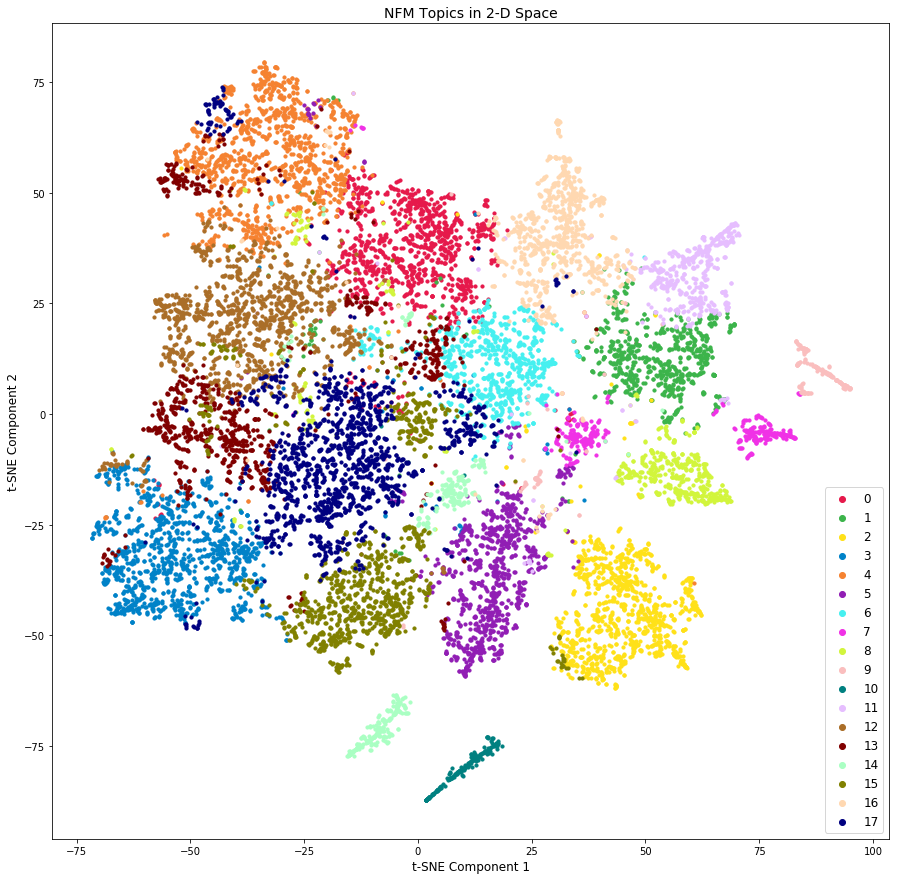

In [243]:
cluster_plot(tsne_data)

## Clustering of NMF-reduced posts

In [65]:
from sklearn.cluster import KMeans

In [66]:
kmeans = KMeans(n_clusters=18).fit_predict(topics_matrix_filtered)

In [67]:
kmeans_topic_per_post = [[x] for x in kmeans]
kmeans_tsne_data = np.concatenate((topics_mapped_2d, kmeans_topic_per_post), 1)

## Export topics to app.py

In [233]:
df['topic'] = max_topic_per_post_df

In [234]:
df.shape

(18366, 13)

In [235]:
app_df = df.dropna()
app_df.shape

(11886, 13)

In [236]:
app_df = app_df.reset_index()
app_df['id'] = app_df.index

In [237]:
df.columns

Index(['body', 'body_len', 'captured', 'city', 'gmap_acc', 'gmap_lat',
       'gmap_lon', 'index', 'prep_body', 'prep_body_keepnum', 'title', 'url',
       'topic'],
      dtype='object')

In [239]:
app_df.id = app_df.id.apply(int)
app_df.title = app_df.title.apply(str)
app_df.topic = app_df.topic.apply(int)
app_df.body = app_df.body.apply(str)
app_df.city = app_df.city.apply(str)
app_df.url = app_df.url.apply(str)

app_df = app_df[['id','title','body','url','topic','city','gmap_lat','gmap_lon']]

In [240]:
app_df.to_json("../data/app_data.json")

## Other visuals

In [286]:
topic_bar = df.topic.value_counts().reset_index().rename(columns={'index':'topic', 'topic':'number of posts'}).sort_values('number of posts')

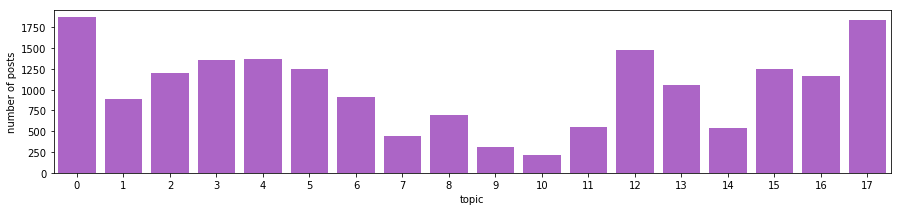

In [307]:
plt.figure(figsize=(15,3))
sns.barplot('topic','number of posts',data=topic_bar, color="#b355d6")

In [377]:
topic_dict = []
no_top_words = 10
for topic_idx, topic in enumerate(nmf.components_):
    topwords = [[topic_idx, feature_names[i], topic[i]] for i in topic.argsort()[:-no_top_words - 1:-1]]
    topic_dict += topwords

In [378]:
top_words_df = pd.DataFrame(topic_dict).rename(columns={0:"Topic", 1:"Word", 2:"NMF Rank"})

In [381]:
topic = 0
top_words_df[top_words_df.Topic == topic][['Word','NMF Rank']]

,Word,NMF Rank
0,song,1.511030
1,re,0.956605
2,ve,0.620347
3,write,0.609427
4,need,0.597098
5,work,0.519816
6,time,0.518620
7,someon,0.513082
8,peopl,0.487354
9,good,0.480049
